In [1]:
# ------------------------------------------------------------------------------
# Description:
#
#  The main program for cloud top height retrieval using two simultaneous 
#  GEO observations.
#
# Method:
#
# (1) Reads two GEO digital number.
# (2) Slicing images and image remapping with KDTree.
# (3) Image matching based on the NCC method.
# (4) Cloud top height retrieval by the iterative process.
# (5) Post-process cloud top height products.
#
# History:
#
# Version  Date      Comment
# -------  ----      -------
# 1.0      19/02/21  Original version.  Jonghyuk Lee (Yonsei Univ.)
# 1.1      20/03/05  Change to Python.  Jonghyuk Lee (Yonsei Univ.)
# 
#
# References:
#
# (1) Hasler, 1981 
#     Stereographic Observations from Geosynchronous Satellties:
#     An Important New Tool for the Atmospheric Sciences.
# (2) Wylie et al., 1998
#     Cloud-Top Heights from GOES-8 and GOES-9 Stereoscopic Imagery.
# (3) Seiz et al., 2007
#     Multiview Cloud-Top Height and Wind Retrieval with Photogrammetric Method:
#     Application to Meteosat-8 HRV Observations.
# (4) Zaksek et al., 2013
#     Monitoring volcanic ash cloud top height through simultaneous retrieval of
#     optical data from polar orbiting and geostationary satellites.
#
#
# Code Description:
#   Language:      Python 3.8
# 
# End of header ----------------------------------------------------------------                                

## 알고리즘 준비

1. Import required libraries

In [10]:
# for importing my modules
import sys
sys.path.append('/sdata_storage/jhlee/JUPYTER/code_dev/module/')

# for checking total time
import time

# for reading datasets
import read_satellite_data as read

# for slicing datasets
import slice_satellite_data as slice

# for remapping (interpolating) datasets
import remap_satellite_data as remap

# for printing total time
import cal_time

import numpy as np
from skimage.feature import match_template
import matplotlib.pyplot as plt

2. Input variables definition

In [3]:
start_time = time.time()

# 입력 파일 경로/날짜
himawari8_path = '/storage1/jhlee/NMSC_2018/Himawari_8_AHI/'
himawari8_date1 = '201711030530'
himawari8_date2 = '201711030540'
fy2e_path = '/storage1/jhlee/NMSC_2018/FY_2E_VISSR/'
fy2e_date = '20171103_0530'

# 목표 영역 정의
left_upper_lat = 30. #32
left_upper_lon = 116. #118
right_lower_lat = 23. #23
right_lower_lon = 127. #132

## 알고리즘 시작

1. 위성자료 읽기
 - Level 1B 위성 자료 읽기 (디지털 값)
 - 위/경도 자료 읽기
 - fy2e 구름 정보 읽기

In [4]:
himawari8 = read.himawari8()
fy2e = read.fy2e()

# Level 1B 디지털 값
himawari8_DN1 = himawari8.read_L1b(himawari8_path, himawari8_date1)
himawari8_DN2 = himawari8.read_L1b(himawari8_path, himawari8_date2)
fy2e_DN, fy2e_clc = fy2e.read_L1b(fy2e_path, fy2e_date)


# 위/경도 자료
himawari8_lat, himawari8_lon = himawari8.read_latlon(himawari8_path)
fy2e_lat, fy2e_lon = fy2e.read_latlon(fy2e_path)

2. 위성자료 리매핑
 - 목표 영역 slicing
 - image remapping

In [5]:
# Himawari-8 목표 영역 slicing (Himawari-8 영역은 조금 더 크게 한다.)
cut_himawari8_DN1 = slice.cut_with_latlon_geos(himawari8_DN1, 'himawari8',
                                               left_upper_lat + 7 , left_upper_lon - 7, 
                                               right_lower_lat - 7, right_lower_lon + 7)
cut_himawari8_DN2 = slice.cut_with_latlon_geos(himawari8_DN2, 'himawari8', 
                                               left_upper_lat + 7 , left_upper_lon - 7, 
                                               right_lower_lat - 7, right_lower_lon + 7)
cut_himawari8_lat = slice.cut_with_latlon_geos(himawari8_lat, 'himawari8', 
                                               left_upper_lat + 7 , left_upper_lon - 7,
                                               right_lower_lat - 7, right_lower_lon + 7)
cut_himawari8_lon = slice.cut_with_latlon_geos(himawari8_lon, 'himawari8', 
                                               left_upper_lat + 7 , left_upper_lon - 7,
                                               right_lower_lat - 7, right_lower_lon + 7)

# FY-2E 목표 영역 slicing
cut_fy2e_DN = slice.cut_with_latlon_geos(fy2e_DN,'fy2e', 
                                         left_upper_lat + 1, left_upper_lon - 1, 
                                         right_lower_lat - 1, right_lower_lon + 1)
cut_fy2e_lat = slice.cut_with_latlon_geos(fy2e_lat, 'fy2e', 
                                          left_upper_lat + 1, left_upper_lon - 1, 
                                          right_lower_lat - 1, right_lower_lon + 1)
cut_fy2e_lon = slice.cut_with_latlon_geos(fy2e_lon, 'fy2e', 
                                          left_upper_lat + 1, left_upper_lon - 1, 
                                          right_lower_lat - 1, right_lower_lon + 1)

# Image remapping (inverse distance weighting with KDTree) : Himawari8 -> FY-2E
interp_himawari8_DN1 = remap.idw_cKDTree(cut_himawari8_lon, cut_himawari8_lat, cut_himawari8_DN1, 
                                         cut_fy2e_lon, cut_fy2e_lat)
interp_himawari8_DN2 = remap.idw_cKDTree(cut_himawari8_lon, cut_himawari8_lat, cut_himawari8_DN2, 
                                         cut_fy2e_lon, cut_fy2e_lat)

# 필요없는 변수 메모리 삭제
del(himawari8_DN1); del(himawari8_DN2); del(himawari8_lat); del(himawari8_lon)
del(fy2e_DN); del(fy2e_lat); del(fy2e_lon)
del(cut_himawari8_lon); del(cut_himawari8_lat); del(cut_himawari8_DN1); del(cut_himawari8_DN2)

3. 위성 이미지 매칭
 - template matching

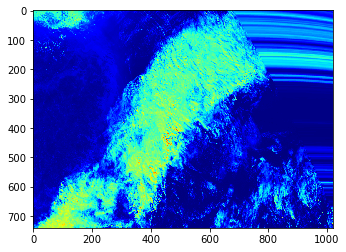

In [6]:
plt.imshow(interp_himawari8_DN1, cmap = plt.cm.jet)

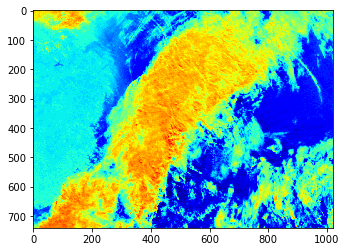

In [7]:
plt.imshow(cut_fy2e_DN, cmap = plt.cm.jet)

total time : 0 hr 22 min 43 sec.


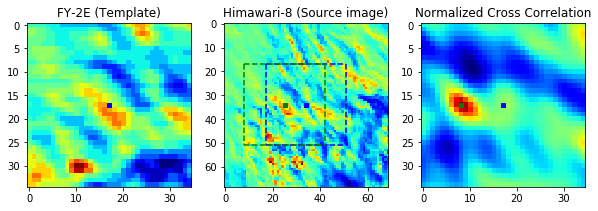

In [49]:
y1 = 400; y2 = y1 + 35
x1 = 450; x2 = x1 + 35
template = cut_fy2e_DN[y1:y2, x1:x2]
image = interp_himawari8_DN1[y1-17:y2+17, x1-17:x2+17]
result = match_template(image, template)

plt.figure(figsize=(10,10))

ax1 = plt.subplot(131)
ax1.imshow(template, cmap = plt.cm.jet)
ax1.plot(int(template.shape[0]/2), int(template.shape[0]/2), 'bs', markersize = 4)
ax1.set_title('FY-2E (Template)')

ax2 = plt.subplot(132)
ax2.imshow(image, cmap = plt.cm.jet)
ax2.plot(int(image.shape[0]/2), int(image.shape[0]/2), 'bs', markersize = 4)
ax2.plot([int(image.shape[0]/2)-17,int(image.shape[0]/2)+17], 
         [int(image.shape[0]/2)-17,int(image.shape[0]/2)-17], 'b--')
ax2.plot([int(image.shape[0]/2)-17,int(image.shape[0]/2)-17], 
         [int(image.shape[0]/2)-17,int(image.shape[0]/2)+17], 'b--')
ax2.plot([int(image.shape[0]/2)+17,int(image.shape[0]/2)+17], 
         [int(image.shape[0]/2)-17,int(image.shape[0]/2)+17], 'b--')
ax2.plot([int(image.shape[0]/2)-17,int(image.shape[0]/2)+17],
         [int(image.shape[0]/2)+17,int(image.shape[0]/2)+17], 'b--')

ax2.plot(int(image.shape[0]/2)-9,int(image.shape[0]/2), 'gs', markersize = 4)
ax2.plot([int(image.shape[0]/2)-9-17, int(image.shape[0]/2)-9+17],
         [int(image.shape[0]/2)-17, int(image.shape[0]/2)-17], 'g--')
ax2.plot([int(image.shape[0]/2)-9-17, int(image.shape[0]/2)-9-17],
         [int(image.shape[0]/2)-17, int(image.shape[0]/2)+17], 'g--')
ax2.plot([int(image.shape[0]/2)-9+17, int(image.shape[0]/2)-9+17],
         [int(image.shape[0]/2)-17, int(image.shape[0]/2)+17], 'g--')
ax2.plot([int(image.shape[0]/2)-9-17, int(image.shape[0]/2)-9+17],
         [int(image.shape[0]/2)+17, int(image.shape[0]/2)+17], 'g--')
ax2.set_title('Himawari-8 (Source image)')


ax3 = plt.subplot(133)
ax3.imshow(result, cmap = plt.cm.jet)
max_lin, max_col = np.unravel_index(result.argmax(), result.shape)
ax3.plot(int(template.shape[0]/2), int(template.shape[0]/2), 'bs', markersize = 4)
ax3.plot(max_col, max_lin, 'gs', markersize = 4)
ax3.set_title('Normalized Cross Correlation')

end_time = time.time()
cal_time.print_tot_time(start_time, end_time)